# Implementing Echo State Networks 

## Introduction

ESN are basically trained by randomizing an hidden layer larger enough to linearize the data and then training the output layer after discard a transient called washout, training can be done by linear regression or ridge regression.

## ESN Architecture

$$
\begin{align*}
\text{Input Layer} & : \mathbf{u}(t) \in \mathbb{R}^{N_{\text{in}}} \\
\text{Hidden Layer} & : \mathbf{x}(t) \in \mathbb{R}^{N_{\text{res}}} \\
\text{Output Layer} & : \mathbf{y}(t) \in \mathbb{R}^{N_{\text{out}}} \\
\end{align*}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Try the class written modularly
from EchoStateNetwork import *

In [2]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)

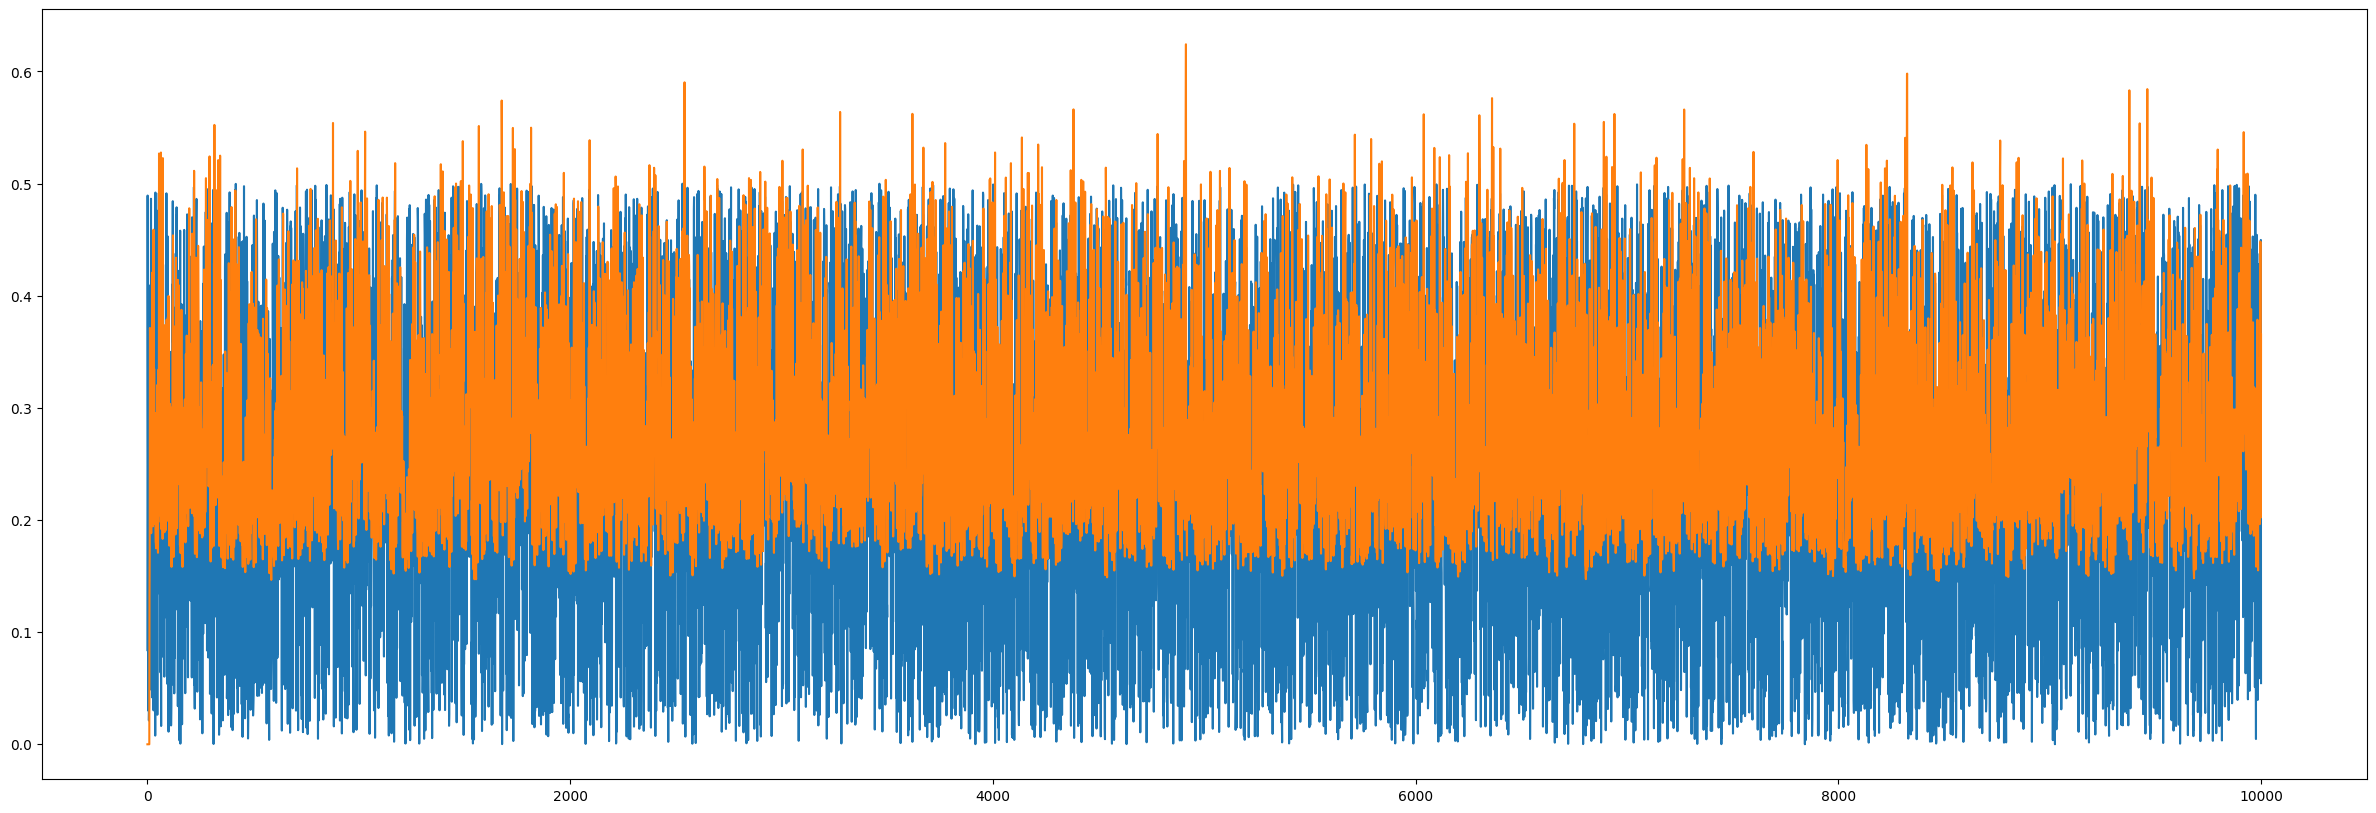

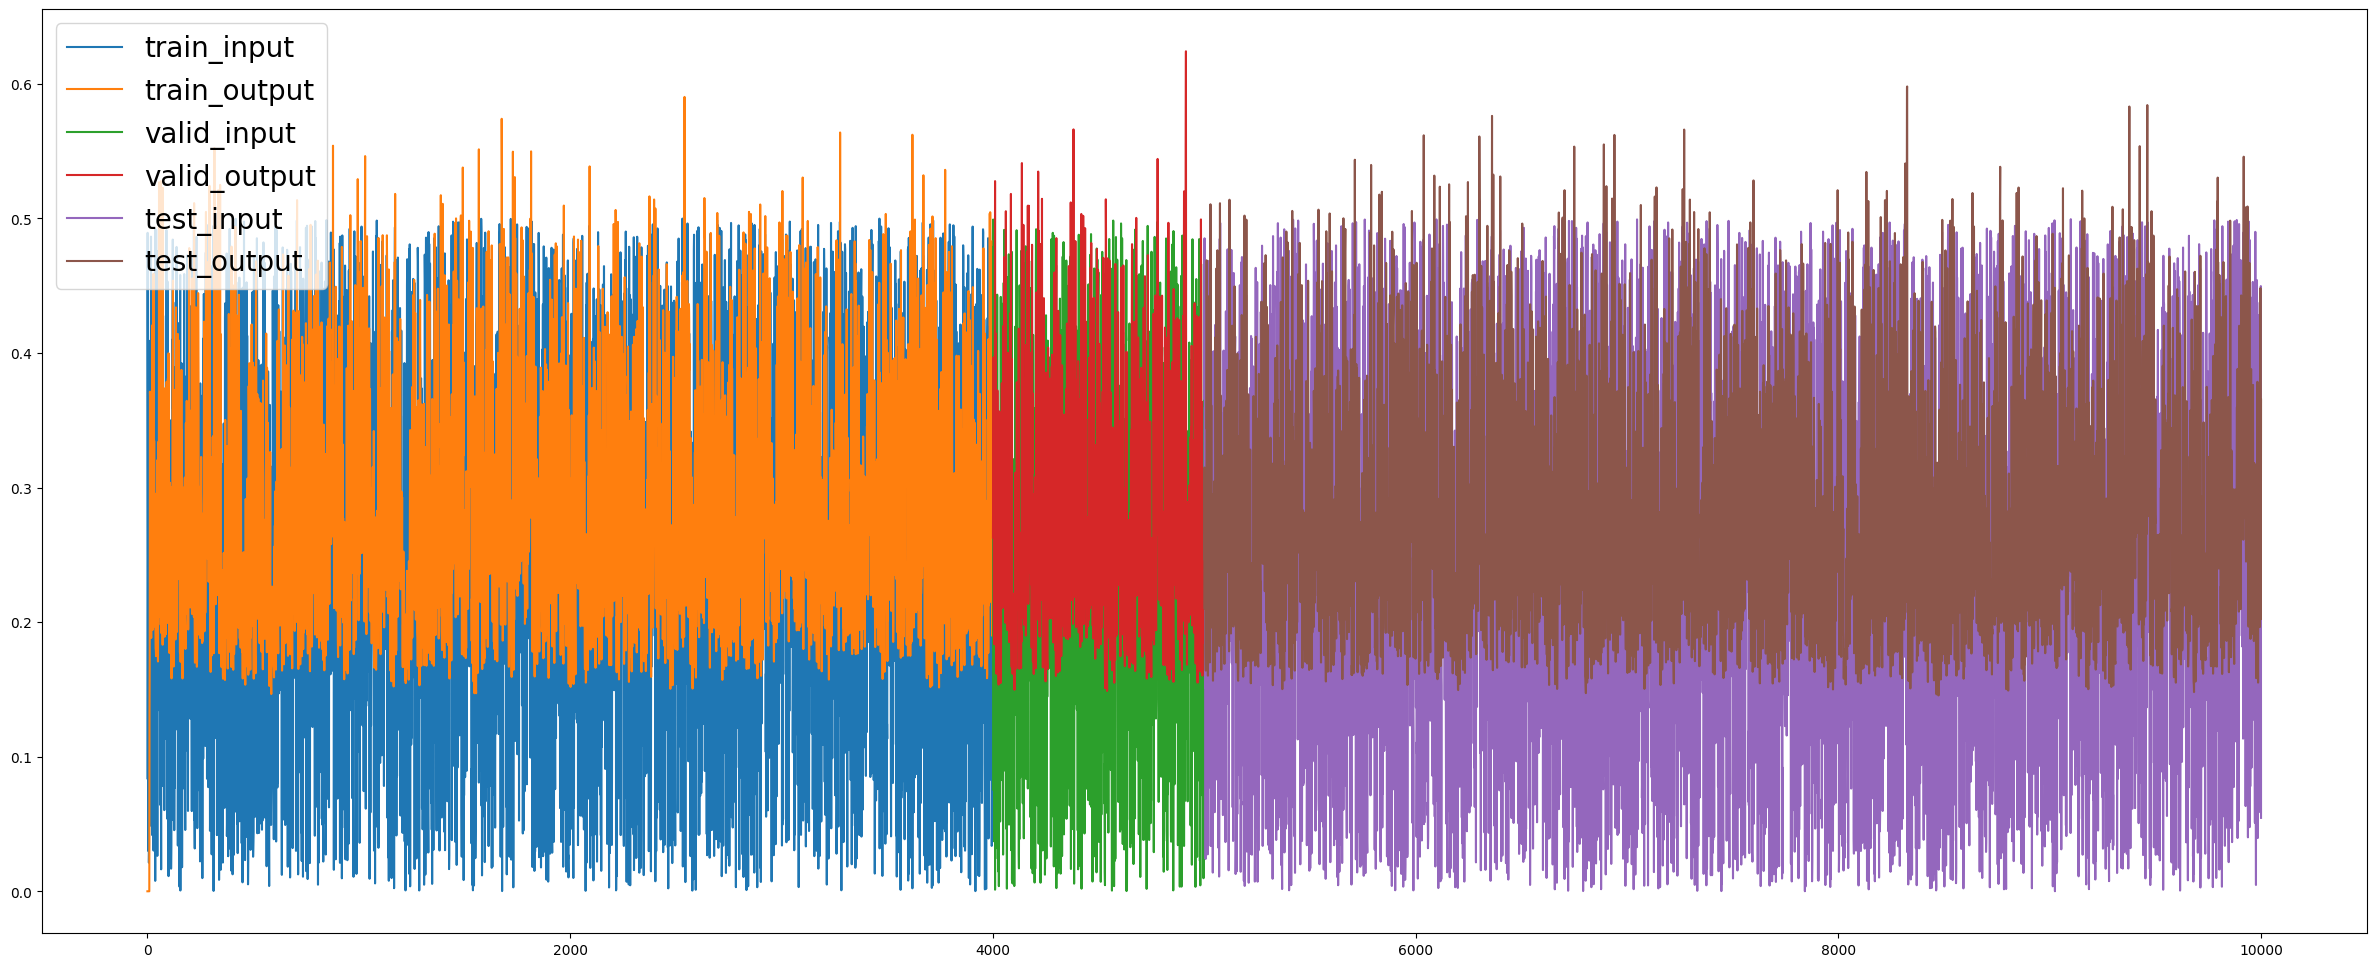

In [3]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [4]:
data_MG17 = pd.read_csv('MG17.csv', header=None)

In [5]:
# divide in train, valid and test the MG17 data, is a single time series of 10000 steps, take 5000 train, 1000 valid and 4000 test
data_MG17.shape
# Index of the timestep is on the columns, so we take first 5000 columns for train, next 1000 for valid and last 4000 for test
train_MG17 = data_MG17.iloc[:, :5000]
valid_MG17 = data_MG17.iloc[:, 5000:6000]
test_MG17 = data_MG17.iloc[:, 6000:]

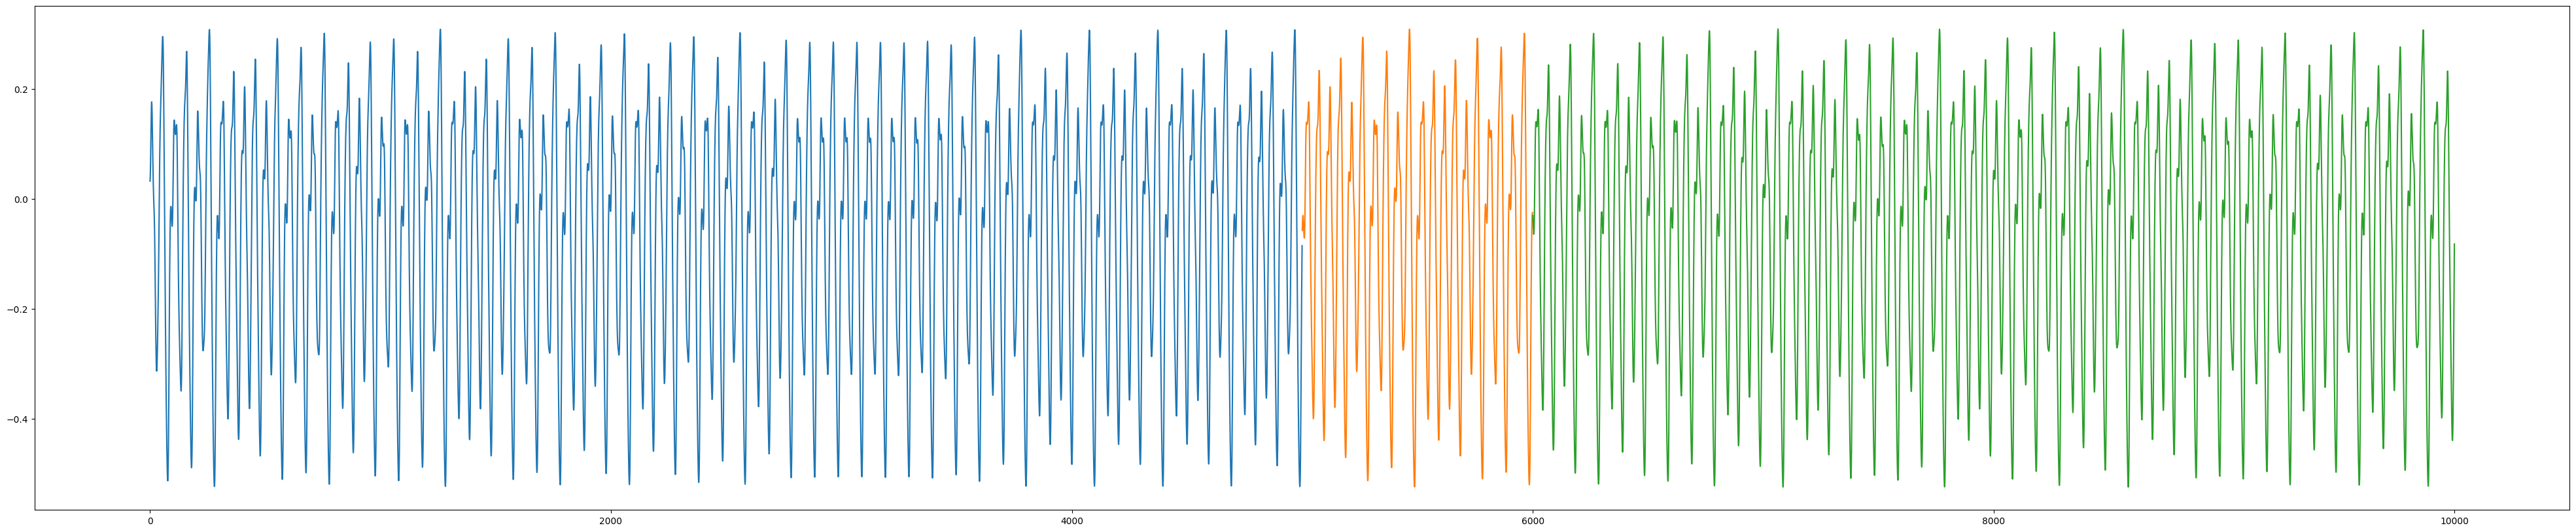

In [6]:
# for each column plot in time series format the data, train, valid and test
plt.figure(figsize=(50,10))
for i in range(0, 1):
    plt.plot(train_MG17.iloc[i])
    plt.plot(valid_MG17.iloc[i])
    plt.plot(test_MG17.iloc[i])

# Let's define our Recurrent Layer as

$$
\begin{align*}
\mathbf{h}(t) & = \tanh(\mathbf{W}_{\text{in}} \mathbf{u}(t) + \mathbf{W_h} \mathbf{x}(t-1) + \mathbf{b}) \\
\end{align*}
$$

### Where we want to enforce this conditions

Sufficient condition for the echo state property is:

$$
\begin{align*}
\rho(\mathbf{W_h}) & = max(\lvert \lambda(\mathbf{W_h}) \rvert) < 1 \\
\end{align*}
$$

And necessary condition for the same matrix to have, but we can violate this condition 

$$
\begin{align*}
||\mathbf{W_h}||_2 & < 1 \\
\end{align*}
$$

In [7]:
#transform train_input and train_output to numpy arrays
#train_input = np.array(train_input).reshape(-1, 1)
#train_output = np.array(train_output).reshape(-1, 1)

train_input, train_output = np.array(train_input), np.array(train_output)
valid_input, valid_output = np.array(valid_input), np.array(valid_output)
test_input, test_output = np.array(test_input), np.array(test_output)

train_input.shape

(4000,)

In [8]:
temp_train_output = train_output.copy()

# Fitting a ESN on the NARMA10 dataset

As we can see from the results we get a very fast approximation of the NARMA10 with a very small error, compared to the classic RNNs and TDNNs.

#### What we notice here with the hyperparameters?

For reservoir's size we better performance with scaling but if we have a too big reservoir even the initialization of this quite big matrix take a lot of time, from my experiments after 1000 the reservoir has a good compromise between performance and time.

Noticeable things on this hyperparameters search was that if we set the $rho$ parameter to 0.9 results are decent but switching to 1 gets better results, but we're violating the sufficient condition for the echo state property. In fact for validation if $\rho$ is set to 0.9 the error is around 0.004 but it decreases to 4e-5 if we set it to 1 or slighly above, this is also influenced by the right $\omega_{in}$ scaling.

In [ ]:
# Restore the train output
train_output = temp_train_output

washout = 500
epochs = len(train_input)
esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 1.2, rho_enforced = 1.1, washout = washout, alternative_method='ridge')

# Train the model
esn.fit(train_input.reshape(-1, 1), train_output, epochs=epochs)

# Predict the output
prediction = esn.predict_test(valid_input.reshape(-1, 1))
# Yeet target 
#valid_output = np.array(valid_output).reshape(-1, 1)
# add washout

# Calculate the error
error = esn.calculate_error(target=valid_output, prediction=prediction)
print('The error is: ', error)

# Plot the prediction
esn.plot_prediction(target=valid_output, prediction=prediction)


### Trying multiple random initializations to have a betters estimate

After a brief parameters search that gives a low enough error we need to estimate the different initialization (these should converge to the same solution by the ESP) and then average the results.

In [ ]:

washout = 500
epochs = len(train_input)
errors = []

for i in range(20):
    
    # Restore the train output
    train_output = temp_train_output

    esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 1.1, rho_enforced = 1, washout = washout, alternative_method='ridge')

    # Let model go trought the data and encode it in the H states and then train our readout
    esn.fit(train_input.reshape(-1, 1), train_output, epochs=epochs)
    
    # Predict the output with test data now
    prediction = esn.predict_test(test_input.reshape(-1, 1))

    # Calculate the error
    error = esn.calculate_error(target=test_output, prediction=prediction)
    
    errors.append(error)
    
    print('The error is: ', error)

# Plot the prediction
esn.plot_prediction(target=test_output, prediction=prediction)

    


In [ ]:
# Calculate and print the variance of the errors
variance = np.var(errors)
print('The variance of the errors is: ', variance)
print('The mean of the errors is: ', np.mean(errors))

# Fitting on Mackey-Glass Time Series

This dataset should be a little bit harder to fit, but we can see that the ESN can approximate the data very well. A

### What we notice here with the hyperparameters?

The here if we sligly increase the rho paremeter over 1, results are better but becomes worse when increasing it too much. For what regards the reservoir size, a bigger reservoir gives better results but we reach a point where the time to train is too high so i just lower the size of the reservoir for this toy dataset.


In [60]:

errors_MG17 = [] 
errors_MG17_smaller = []
washout_MG17 = 1000

# add delay to the target
delay = 3

# for training we need a delayed version
train_MG17 = np.array(train_MG17).reshape(-1, 1)
epochs_MG17 = len(train_MG17)
train_input_MG17 = train_MG17
target_delayed_MG17 = train_MG17[washout_MG17+delay:epochs_MG17]

# Now to predict we just go with the valid and test data, valid is 1000 steps and test is 4000
valid_MG17 = np.array(valid_MG17).reshape(-1, 1)
test_MG17 = np.array(test_MG17).reshape(-1, 1)

# Help for restore trin output
train_MG17_copy = train_MG17
valid_input_MG17 = valid_MG17
test_input_MG17 = test_MG17


The error is:  0.09281385730473748


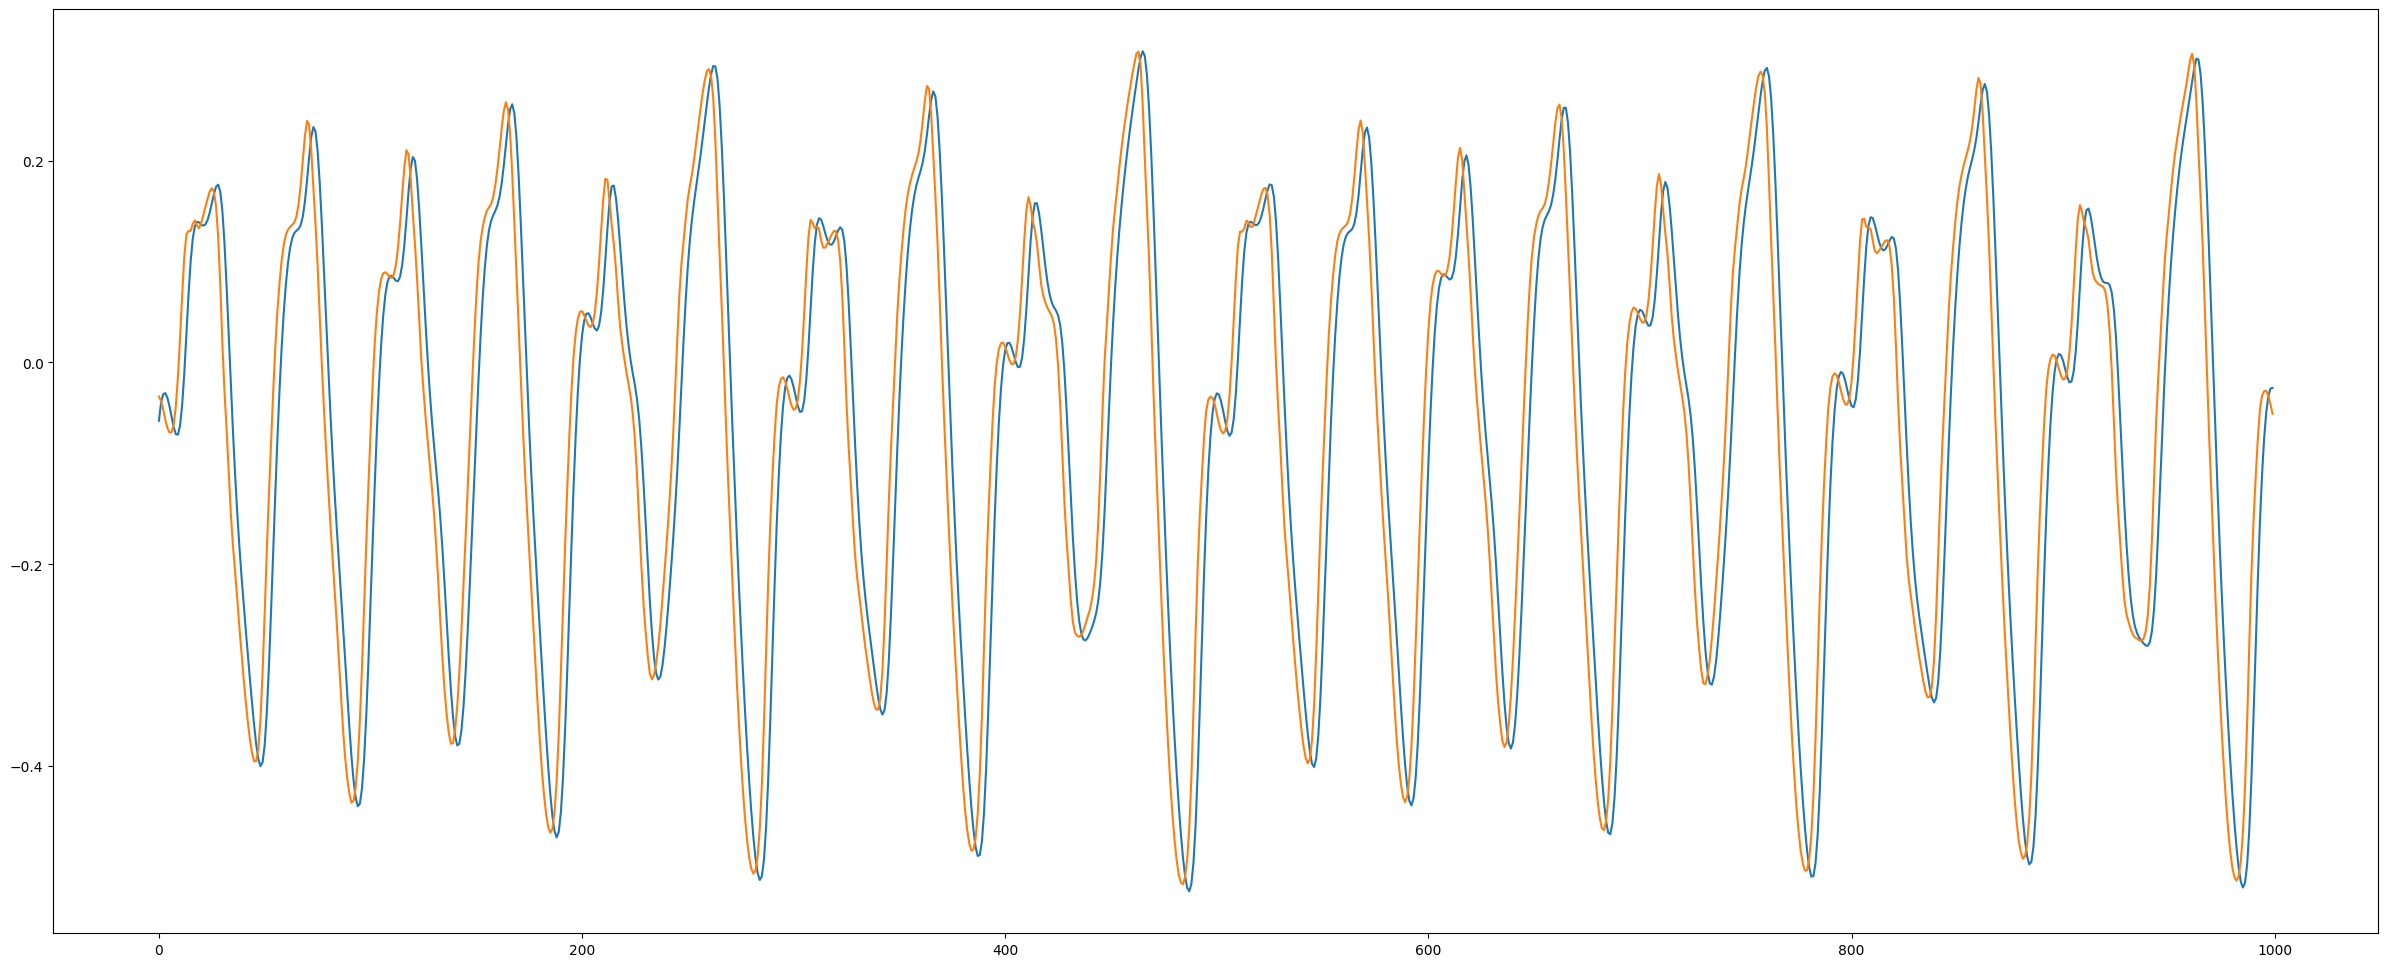

In [61]:
esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 1.2, rho_enforced = 1.1, washout = washout_MG17, alternative_method='ridge')

# restore data

# Let model go trought the data and encode it in the H states and then train our readout
esn.fit(train_input_MG17, target_delayed_MG17, epochs = epochs_MG17, delay = delay)

# Predict the output
prediction_MG17 = esn.predict_test(valid_MG17)

# Adjust target (train_output) using washout
#target_delayed_MG17 = target_delayed_MG17[washout_MG17:epochs_MG17]

# Remove the washout for prediction
#prediction_MG17 = prediction_MG17[washout_MG17:epochs_MG17]

# calculate the error MSE taking delay into account
#error_MG17 = np.mean((valid_MG17[delay:] - prediction_MG17)**2)
error_MG17 = esn.calculate_error(target=valid_MG17, prediction=prediction_MG17)
errors_MG17.append(error_MG17)

print('The error is: ', error_MG17)

# Plot the prediction taking delay into account
esn.plot_prediction(target=valid_MG17, prediction=prediction_MG17)

### Trying multiple random initializations to have a betters estimate for the Mackey-Glass Time Series

In [41]:
for i in range(10):
       
        # Restore the train output and target
        train_MG17 = train_MG17_copy
        target_delayed_MG17 = train_MG17[washout_MG17+delay:epochs_MG17]
        
        esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 0.8, rho_enforced = 1.1, washout = washout_MG17, alternative_method='ridge')
        
        # Let model go trought the data and encode it in the H states and then train our readout
        esn.fit(train_input_MG17, target_delayed_MG17, epochs = epochs_MG17, delay = delay)
        
        # Predict the output
        prediction_MG17 = esn.predict_test(test_MG17)
        
        # Adjust target (train_output) using washout
        #target_delayed_MG17 = target_delayed_MG17[washout_MG17:epochs_MG17]
        
        # Remove the washout for prediction
        #prediction_MG17 = prediction_MG17[washout_MG17:epochs_MG17]
        
        error_MG17 = esn.calculate_error(target=test_MG17, prediction=prediction_MG17)
        
        errors_MG17.append(error_MG17)
        
        print(f'The error in run {i+1} is: ', error_MG17)
        

The error in run 1 is:  0.09374542053028648
The error in run 2 is:  0.0937446163301753
The error in run 3 is:  0.09366290127274199
The error in run 4 is:  0.09368985138384604
The error in run 5 is:  0.09371993656153255
The error in run 6 is:  0.09371809871985314
The error in run 7 is:  0.09373001748399701
The error in run 8 is:  0.09372476974960361
The error in run 9 is:  0.09377685125457509
The error in run 10 is:  0.0937044040628194


The variance of the errors is:  6.93977941425894e-08
The mean of the errors is:  0.09363887364870536


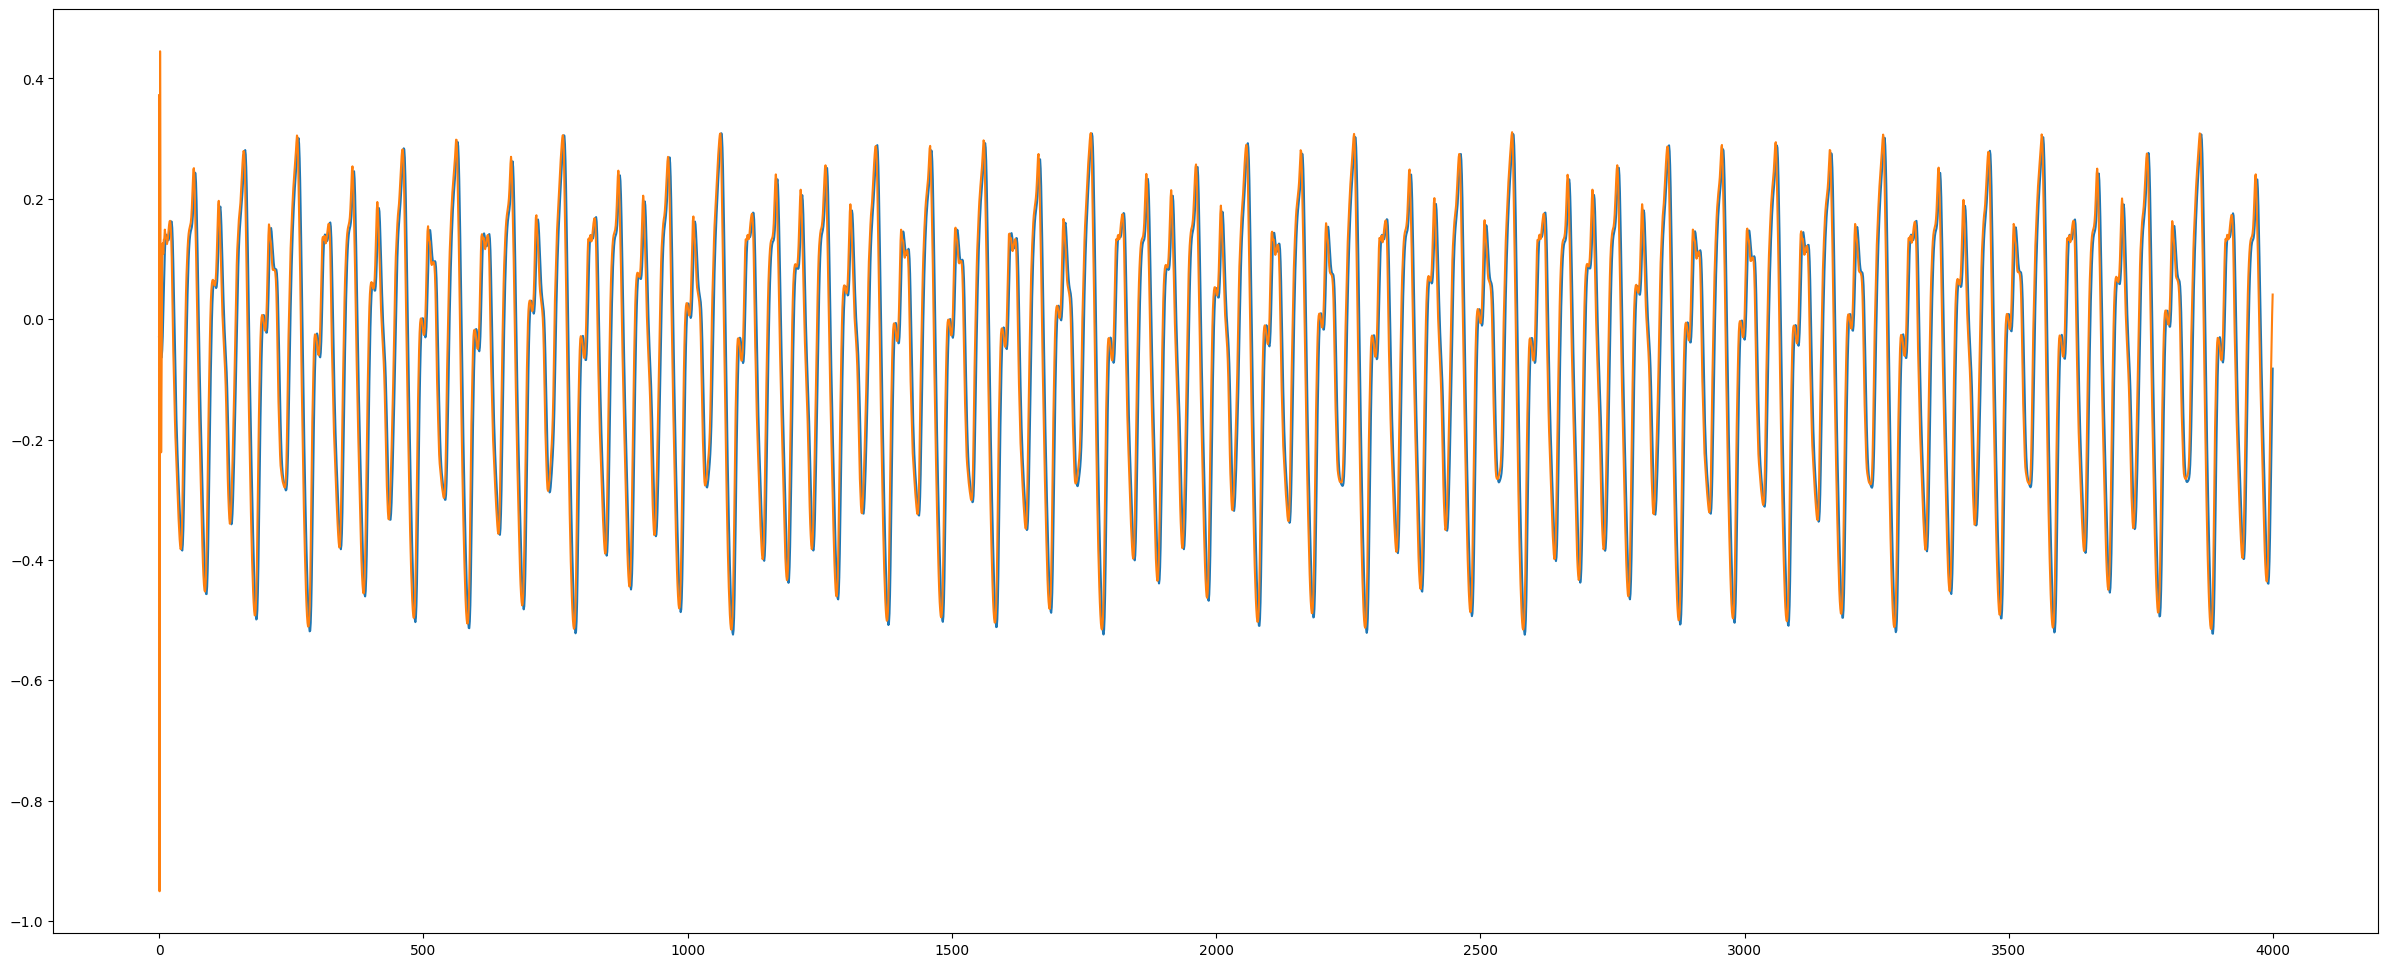

In [43]:
# Calculate and print the variance of the errors
variance = np.var(errors_MG17)

print('The variance of the errors is: ', variance)
print('The mean of the errors is: ', np.mean(errors_MG17))

# Plot the prediction
esn.plot_prediction(target=test_MG17, prediction=prediction_MG17)



# Trying on MNIST dataset sequentially

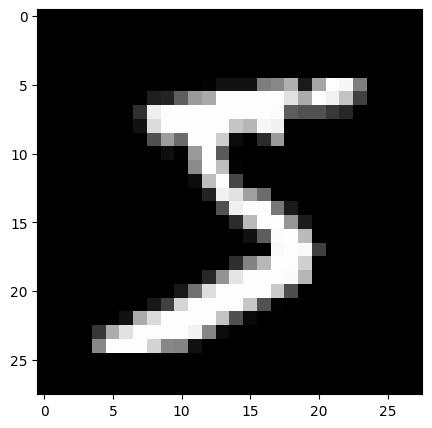

In [44]:
# import mnist
from keras.datasets import mnist

# train, valid and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# plot the first image
plt.figure(figsize=(5,5))
plt.imshow(train_images[0], cmap='gray')

In [ ]:
# convert the data to a single vector from 28x28 to 784
train_images = train_images.reshape(60000, 784)
# get test labels
train_labels = train_labels

# show flattened array for space reasons after 100 steps we go to the next line
plt.figure(figsize=(10,10))

# plt the images in time series format
# take 10 images
    
# use the code above and make that we have 4 images in subpltos
plt.figure(figsize=(30,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(train_images[i])
    plt.title('Label: ' + str(train_labels[i]))
    plt.plot()
    

In [ ]:
train_images[0].shape

In [ ]:
train_images = train_images.reshape(-1,1)

## Problem with training on SeqMNIST

Since we have a dataset of 60k images we're flattening them and then proceeding to train the ESN we have an aburdly long number of steps to go with our hidden matrix, and we need to speed up since with current implementation as the matrix grow in size the time becomes really long to get our hidden representation for all the training set.

In fact with th first 2000 "steps" we get to only 0.22 accuracy

In [ ]:
timesteps_MNIST = 2000
washout = 216
train_input = train_images[:timesteps_MNIST]
train_output = train_labels[:timesteps_MNIST]

# Run ESN on Sequential MNIST
esn = EchoStateNetwork(N_h = 2000, N_x = 1, omega_in = 0.9, rho_enforced = 0.9, washout = washout,
                       alternative_method='classification')

# Let model go trought the data and encode it in the H states and then train our readout
esn.fit(train_input, train_output, epochs = timesteps_MNIST)
